In [1]:
import pandas as pd
import duckdb
import time
pd.set_option('display.max_columns', None)

In [2]:
# Return Speed in km/h from distance and time
def to_km_h(distance, time):
    if time != 0:
        return distance/time * (3600/1000)
    return 0
# Return time in secodnes from distance and speed
def to_time(distance, speed):
    if speed != 0:
        return distance/speed * (3600/1000)
    return 0

# Compute duration between two timestamps
def duration(time1, time2):
    hour1,minute1,second1 = [int(x) for x in time1.split(':')]
    hour2,minute2,second2 = [int(x) for x in time2.split(':')]
    if hour1 < 3 and hour2 > 20:
        hour1 = hour1 + 24
    if hour1 > 20 and hour2 < 3:
        hour2 = hour2 + 24
    return hour1*3600 + minute1*60 + second1 - hour2*3600 - minute2*60 - second2

In [3]:
# Reframe the schedule dataframe where each line was a node to a dataframe where each line is an edge
def reframe_df(df):
    col = {'DATDEP': [], 'TRAIN_NO': [], 'RELATION': [], 'REAL_TIME': [], 'PLANNED_TIME': [], 'DELAY_DEP':[],
           'NODE_1': [], 'PTCAR_1': [], 'LINE_NO_1': [], 'PTCAR_ID_1': [],
           'NODE_2': [], 'PTCAR_2': [], 'LINE_NO_2': [], 'PTCAR_ID_2': [], 'HOUR': []}
    
    for ind in df.index:
        if ind+1 == len(df.index):
            break
        if df['TRAIN_NO'][ind] == df['TRAIN_NO'][ind+1] and df['DATDEP'][ind] == df['DATDEP'][ind+1]:
            col['DATDEP'].append(df['DATDEP'][ind])
            col['TRAIN_NO'].append(df['TRAIN_NO'][ind])
            col['RELATION'].append(df['RELATION'][ind])
            col['REAL_TIME'].append(duration(df['REAL_TIME_DEP'][ind+1], df['REAL_TIME_DEP'][ind]))
            col['PLANNED_TIME'].append(duration(df['PLANNED_TIME_DEP'][ind+1], df['PLANNED_TIME_DEP'][ind]))
            col['DELAY_DEP'].append(duration(df['REAL_TIME_DEP'][ind], df['PLANNED_TIME_DEP'][ind]))
            col['NODE_1'].append(df['PTCAR_LG_NM_NL'][ind]+'_'+df['LINE_NO_DEP'][ind])
            col['PTCAR_1'].append(df['PTCAR_LG_NM_NL'][ind])
            col['LINE_NO_1'].append(df['LINE_NO_DEP'][ind])
            col['PTCAR_ID_1'].append(df['PTCAR_NO'][ind])
            col['NODE_2'].append(df['PTCAR_LG_NM_NL'][ind+1]+'_'+df['LINE_NO_DEP'][ind+1])
            col['PTCAR_2'].append(df['PTCAR_LG_NM_NL'][ind+1])
            col['LINE_NO_2'].append(df['LINE_NO_DEP'][ind+1])
            col['PTCAR_ID_2'].append(df['PTCAR_NO'][ind+1])
            col['HOUR'].append(int(df['REAL_TIME_DEP'][ind].split(':')[0]))
        
    df = pd.DataFrame(data=col)
    
    return df


In [4]:
# Same in SQL with duckdb
def reframe_df_duckdb(df):
    sql = """
        WITH sq AS (
            SELECT
                strptime(DATDEP, '%d%b%Y') AS DATDEP,
                TRAIN_NO,
                RELATION,
                TRAIN_SERV,
                PTCAR_NO,
                LINE_NO_DEP,
                CAST(strptime(REAL_DATE_ARR,    '%d%b%Y') AS DATE) + CAST(strptime(REAL_TIME_ARR,    '%-H:%M:%S') AS TIME) AS REAL_DT_ARR,
                CAST(strptime(REAL_DATE_DEP,    '%d%b%Y') AS DATE) + CAST(strptime(REAL_TIME_DEP,    '%-H:%M:%S') AS TIME) AS REAL_DT_DEP,
                CAST(strptime(PLANNED_DATE_ARR, '%d%b%Y') AS DATE) + CAST(strptime(PLANNED_TIME_ARR, '%-H:%M:%S') AS TIME) AS PLANNED_DT_ARR,
                CAST(strptime(PLANNED_DATE_DEP, '%d%b%Y') AS DATE) + CAST(strptime(PLANNED_TIME_DEP, '%-H:%M:%S') AS TIME) AS PLANNED_DT_DEP,
                DELAY_ARR,
                DELAY_DEP,
                PTCAR_LG_NM_NL,
                LINE_NO_ARR,
                i,
            FROM
                df
        ), shifted AS (
            SELECT
                *,
                LEAD(PTCAR_LG_NM_NL) OVER w AS NEXT_PTCAR_LG_NM_NL,
                LEAD(LINE_NO_ARR) OVER w AS NEXT_LINE_NO_ARR,
                LEAD(PTCAR_NO) OVER w AS NEXT_PTCAR_NO,
                LEAD(LINE_NO_DEP) OVER w AS NEXT_LINE_NO_DEP,
                LEAD(REAL_DT_ARR) OVER w AS NEXT_REAL_DT_ARR,
                LEAD(REAL_DT_DEP) OVER w AS NEXT_REAL_DT_DEP,
                LEAD(PLANNED_DT_ARR) OVER w AS NEXT_PLANNED_DT_ARR,
                LEAD(PLANNED_DT_DEP) OVER w AS NEXT_PLANNED_DT_DEP,
            FROM
                sq
            WINDOW w AS (PARTITION BY TRAIN_NO, DATDEP ORDER BY i)
        )
        SELECT
            DATDEP,
            TRAIN_NO,
            RELATION,
            EXTRACT('epoch' FROM (NEXT_REAL_DT_DEP - REAL_DT_DEP)) AS REAL_TIME,
            EXTRACT('epoch' FROM (NEXT_PLANNED_DT_DEP - PLANNED_DT_DEP)) AS PLANNED_TIME,
            EXTRACT('epoch' FROM (REAL_DT_DEP - PLANNED_DT_DEP)) AS DELAY_DEP,
            PTCAR_LG_NM_NL || '_' || LINE_NO_DEP AS NODE_1,
            PTCAR_LG_NM_NL AS PTCAR_1,
            LINE_NO_DEP AS LINE_NO_1,
            PTCAR_NO AS PTCAR_ID_1,
            NEXT_PTCAR_LG_NM_NL || '_' || NEXT_LINE_NO_DEP AS NODE_2,
            NEXT_PTCAR_LG_NM_NL AS PTCAR_2,
            NEXT_LINE_NO_DEP AS LINE_NO_2,
            NEXT_PTCAR_NO AS PTCAR_ID_2,
            EXTRACT('hour' FROM REAL_DT_DEP) AS HOUR,
        FROM
            shifted
        WHERE
            NEXT_PTCAR_NO IS NOT NULL
        ORDER BY
            DATDEP, TRAIN_NO, REAL_DT_DEP
    """
    return duckdb.sql(sql).df()

In [5]:
# Same using only Pandas functions (no loop, no apply)
def reframe_df_pandas(df):
    df['DATDEP'] = pd.to_datetime(df['DATDEP'], format='%d%b%Y')
    df['REAL_DT_ARR'] = pd.to_datetime(df['REAL_DATE_ARR'] + ' ' + df['REAL_TIME_ARR'], format='%d%b%Y %H:%M:%S')
    df['REAL_DT_DEP'] = pd.to_datetime(df['REAL_DATE_DEP'] + ' ' + df['REAL_TIME_DEP'], format='%d%b%Y %H:%M:%S')
    df['PLANNED_DT_ARR'] = pd.to_datetime(df['PLANNED_DATE_ARR'] + ' ' + df['PLANNED_TIME_ARR'], format='%d%b%Y %H:%M:%S')
    df['PLANNED_DT_DEP'] = pd.to_datetime(df['PLANNED_DATE_DEP'] + ' ' + df['PLANNED_TIME_DEP'], format='%d%b%Y %H:%M:%S')
    df['NODE'] = df['PTCAR_LG_NM_NL'] + '_' + df['LINE_NO_DEP']
                    
    # Create copy of df with index incremented by 1 -> starting at second row with index=1 and add auffix to all columns
    df_next = df[1:].reset_index().add_suffix('_2')
    
    df_concat = pd.concat([df, df_next], axis=1)
    df_concat['REAL_TIME'] = (df_concat['REAL_DT_DEP_2'] - df_concat['REAL_DT_DEP']).dt.total_seconds()
    df_concat['PLANNED_TIME'] = (df_concat['PLANNED_DT_DEP_2'] - df_concat['PLANNED_DT_DEP']).dt.total_seconds()
    df_concat['DELAY_DEP'] = (df_concat['REAL_DT_DEP'] - df_concat['PLANNED_DT_DEP']).dt.total_seconds()
    df_concat['HOUR'] = df_concat['REAL_DT_DEP'].dt.hour
    
    
    df_final = df_concat.loc[
        # keep rows where train and date departure are the same
        (df_concat['TRAIN_NO'] == df_concat['TRAIN_NO_2']) & (df_concat['DATDEP'] == df_concat['DATDEP_2']), 
        [
            'DATDEP',
            'TRAIN_NO',
            'RELATION',
            'REAL_TIME',
            'PLANNED_TIME',
            'DELAY_DEP',
            'NODE',
            'PTCAR_LG_NM_NL',
            'LINE_NO_DEP',
            'PTCAR_NO',
            'NODE_2',
            'PTCAR_LG_NM_NL_2',
            'LINE_NO_DEP_2',
            'PTCAR_NO_2',
            'HOUR',
        ],
    ].reset_index()
    
    # rename to same column names as other examples
    return df_final.rename(columns={
        'NODE': 'NODE_1',
        'PTCAR_LG_NM_NL': 'PTCAR_1',
        'LINE_NO_DEP': 'LINE_NO_1',
        'PTCAR_NO': 'PTCAR_ID_1',
        'PTCAR_LG_NM_NL_2': 'PTCAR_2',
        'LINE_NO_DEP_2': 'LINE_NO_2',
        'PTCAR_NO_2': 'PTCAR_ID_2',
    })

In [6]:
# df_csv = pd.read_csv('https://fr.ftp.opendatasoft.com/infrabel/PunctualityHistory/Data_raw_punctuality_202302.csv')
df = pd.read_csv('Data_raw_punctuality_202302.csv')

In [7]:
# Repair DataFrame
df.loc[pd.isnull(df['PLANNED_TIME_ARR']), 'PLANNED_TIME_ARR'] = df.loc[pd.isnull(df['PLANNED_TIME_ARR']),'PLANNED_TIME_DEP']
df.loc[pd.isnull(df['PLANNED_TIME_DEP']), 'PLANNED_TIME_DEP'] = df.loc[pd.isnull(df['PLANNED_TIME_DEP']),'PLANNED_TIME_ARR']
df.loc[pd.isnull(df['REAL_TIME_ARR']), 'REAL_TIME_ARR'] = df.loc[pd.isnull(df['REAL_TIME_ARR']),'REAL_TIME_DEP']
df.loc[pd.isnull(df['REAL_TIME_DEP']), 'REAL_TIME_DEP'] = df.loc[pd.isnull(df['REAL_TIME_DEP']),'REAL_TIME_ARR']
df.loc[pd.isnull(df['PLANNED_DATE_ARR']), 'PLANNED_DATE_ARR'] = df.loc[pd.isnull(df['PLANNED_DATE_ARR']),'PLANNED_DATE_DEP']
df.loc[pd.isnull(df['PLANNED_DATE_DEP']), 'PLANNED_DATE_DEP'] = df.loc[pd.isnull(df['PLANNED_DATE_DEP']),'PLANNED_DATE_ARR']
df.loc[pd.isnull(df['REAL_DATE_ARR']), 'REAL_DATE_ARR'] = df.loc[pd.isnull(df['REAL_DATE_ARR']),'REAL_DATE_DEP']
df.loc[pd.isnull(df['REAL_DATE_DEP']), 'REAL_DATE_DEP'] = df.loc[pd.isnull(df['REAL_DATE_DEP']),'REAL_DATE_ARR']
df.loc[pd.isnull(df['LINE_NO_DEP']), 'LINE_NO_DEP'] = 'noline'
df['i'] = df.index

In [8]:
df

,DATDEP,TRAIN_NO,RELATION,TRAIN_SERV,PTCAR_NO,LINE_NO_DEP,REAL_TIME_ARR,REAL_TIME_DEP,PLANNED_TIME_ARR,PLANNED_TIME_DEP,DELAY_ARR,DELAY_DEP,RELATION_DIRECTION,PTCAR_LG_NM_NL,LINE_NO_ARR,PLANNED_DATE_ARR,PLANNED_DATE_DEP,REAL_DATE_ARR,REAL_DATE_DEP,i
0,01FEB2023,11,ICE,SNCB/NMBS,220,0/1,6:23:35,6:23:35,6:23:00,6:23:00,NaN,35.0,ICE: BRUSSEL-ZUID -> FRANKFURT(MAIN) HBF,BRUSSEL-ZUID,NaN,01FEB2023,01FEB2023,01FEB2023,01FEB2023,0
1,01FEB2023,11,ICE,SNCB/NMBS,217,0/1,6:25:50,6:25:50,6:25:00,6:25:00,50.0,50.0,ICE: BRUSSEL-ZUID -> FRANKFURT(MAIN) HBF,BRUSSEL-KAPELLEKERK,0/1,01FEB2023,01FEB2023,01FEB2023,01FEB2023,1
2,01FEB2023,11,ICE,SNCB/NMBS,215,0/1,6:26:43,6:26:43,6:26:00,6:26:00,43.0,43.0,ICE: BRUSSEL-ZUID -> FRANKFURT(MAIN) HBF,BRUSSEL-CENTRAAL,0/1,01FEB2023,01FEB2023,01FEB2023,01FEB2023,2
3,01FEB2023,11,ICE,SNCB/NMBS,216,0/1,6:27:47,6:27:47,6:27:00,6:27:00,47.0,47.0,ICE: BRUSSEL-ZUID -> FRANKFURT(MAIN) HBF,BRUSSEL-CONGRES,0/1,01FEB2023,01FEB2023,01FEB2023,01FEB2023,3
4,01FEB2023,11,ICE,SNCB/NMBS,221,36N,6:29:50,6:31:47,6:29:00,6:31:00,50.0,47.0,ICE: BRUSSEL-ZUID -> FRANKFURT(MAIN) HBF,BRUSSEL-NOORD,0/1,01FEB2023,01FEB2023,01FEB2023,01FEB2023,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1774542,28FEB2023,17209,EXTRA,SNCB/NMBS,1232,15,18:29:48,18:29:48,18:35:00,18:35:00,-311.0,-311.0,NaN,WOLFSTEE,15,28FEB2023,28FEB2023,28FEB2023,28FEB2023,1774542
1774543,28FEB2023,17209,EXTRA,SNCB/NMBS,199,15,18:31:24,18:31:24,18:36:00,18:36:00,-276.0,-276.0,NaN,BOUWEL,15,28FEB2023,28FEB2023,28FEB2023,28FEB2023,1774543
1774544,28FEB2023,17209,EXTRA,SNCB/NMBS,907,15,18:34:20,18:34:20,18:39:00,18:39:00,-280.0,-280.0,NaN,NIJLEN,15,28FEB2023,28FEB2023,28FEB2023,28FEB2023,1774544
1774545,28FEB2023,17209,EXTRA,SNCB/NMBS,635,15,18:36:11,18:36:11,18:42:00,18:42:00,-349.0,-349.0,NaN,KESSEL,15,28FEB2023,28FEB2023,28FEB2023,28FEB2023,1774545


In [9]:
times = []

In [10]:
start = time.time()
df1 = reframe_df(df.copy())
end = time.time()
times.append(dict(name='for loop', time=(end - start)))

In [11]:
start = time.time()
df2 = reframe_df_duckdb(df.copy())
end = time.time()
times.append(dict(name='duckdb', time=(end - start)))

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [12]:
start = time.time()
df3 = reframe_df_pandas(df.copy())
end = time.time()
times.append(dict(name='pandas', time=(end - start)))

<Axes: xlabel='name'>

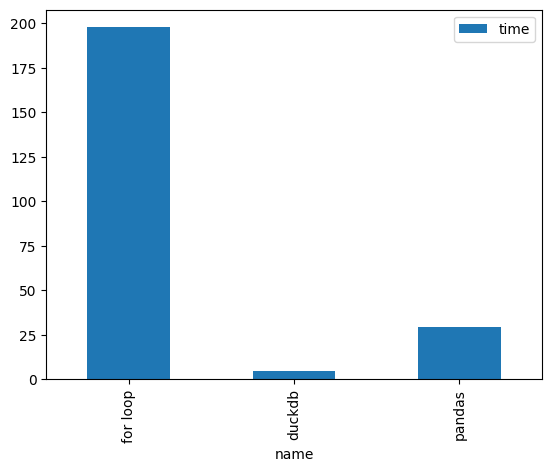

In [13]:
pd.DataFrame(times).set_index('name').plot(kind='bar')

In [14]:
df1.loc[df1['PTCAR_1'] == 'CHARLEROI-CENTRAL',:].groupby(['LINE_NO_1', 'LINE_NO_2', 'PTCAR_2'])['REAL_TIME'].aggregate(['count', 'min', 'median', 'mean', 'max'])

count  min  median        mean   max
LINE_NO_1 LINE_NO_2 PTCAR_2                                                   
124       112       MARCHIENNE-AU-PONT       79  224   343.0  348.772152   773
          124       MARCHIENNE-AU-PONT     1105  231   327.0  328.260633   891
          124A      MARCHIENNE-AU-PONT       21  315   409.0  441.714286   867
          130A      MARCHIENNE-ZONE           3  361   506.0  465.666667   530
          132       JAMIOULX                  5  612   667.0  687.200000   759
124A      112       MARCHIENNE-AU-PONT     1161  163   302.0  298.959518   973
          124A      MARCHIENNE-AU-PONT       82  285   410.0  402.597561   626
          130A      MARCHIENNE-ZONE          11  349   404.0  431.727273   706
          132       JAMIOULX                  5  644   691.0  712.200000   788
124L/2    124L/2    CHARLEROI-FAISCEAU A      3   73    77.0   75.666667    77
          noline    CHARLEROI-FAISCEAU A      1   41    41.0   41.000000    41
130       130       COUILLET               1150   60   151.0  174.144348   585
130A      130A      MARCHIENNE-ZONE         399  293   373.0  397.894737  2806
          132       JAMIOULX                457  584   682.0  698.091904  1005
130C      130C      COUILLET                346  264   369.0  369.471098   579
140/1     140       CHARLEROI-OUEST         467  133   220.0  221.751606   477
          noline    CHARLEROI-OUEST           1  163   163.0  163.000000   163

In [15]:
df2.loc[df2['PTCAR_1'] == 'CHARLEROI-CENTRAL',:].groupby(['LINE_NO_1', 'LINE_NO_2', 'PTCAR_2'])['REAL_TIME'].aggregate(['count', 'min', 'median', 'mean', 'max'])

count  min  median        mean   max
LINE_NO_1 LINE_NO_2 PTCAR_2                                                   
124       112       MARCHIENNE-AU-PONT       79  224   343.0  348.772152   773
          124       MARCHIENNE-AU-PONT     1105  231   327.0  328.260633   891
          124A      MARCHIENNE-AU-PONT       21  315   409.0  441.714286   867
          130A      MARCHIENNE-ZONE           3  361   506.0  465.666667   530
          132       JAMIOULX                  5  612   667.0  687.200000   759
124A      112       MARCHIENNE-AU-PONT     1161  163   302.0  298.959518   973
          124A      MARCHIENNE-AU-PONT       82  285   410.0  402.597561   626
          130A      MARCHIENNE-ZONE          11  349   404.0  431.727273   706
          132       JAMIOULX                  5  644   691.0  712.200000   788
124L/2    124L/2    CHARLEROI-FAISCEAU A      3   73    77.0   75.666667    77
          noline    CHARLEROI-FAISCEAU A      1   41    41.0   41.000000    41
130       130       COUILLET               1150   60   151.0  174.144348   585
130A      130A      MARCHIENNE-ZONE         399  293   373.0  397.894737  2806
          132       JAMIOULX                457  584   682.0  698.091904  1005
130C      130C      COUILLET                346  264   369.0  369.471098   579
140/1     140       CHARLEROI-OUEST         467  133   220.0  221.751606   477
          noline    CHARLEROI-OUEST           1  163   163.0  163.000000   163

In [16]:
df3.loc[df3['PTCAR_1'] == 'CHARLEROI-CENTRAL',:].groupby(['LINE_NO_1', 'LINE_NO_2', 'PTCAR_2'])['REAL_TIME'].aggregate(['count', 'min', 'median', 'mean', 'max'])

count    min  median        mean  \
LINE_NO_1 LINE_NO_2 PTCAR_2                                                  
124       112       MARCHIENNE-AU-PONT       79  224.0   343.0  348.772152   
          124       MARCHIENNE-AU-PONT     1105  231.0   327.0  328.260633   
          124A      MARCHIENNE-AU-PONT       21  315.0   409.0  441.714286   
          130A      MARCHIENNE-ZONE           3  361.0   506.0  465.666667   
          132       JAMIOULX                  5  612.0   667.0  687.200000   
124A      112       MARCHIENNE-AU-PONT     1161  163.0   302.0  298.959518   
          124A      MARCHIENNE-AU-PONT       82  285.0   410.0  402.597561   
          130A      MARCHIENNE-ZONE          11  349.0   404.0  431.727273   
          132       JAMIOULX                  5  644.0   691.0  712.200000   
124L/2    124L/2    CHARLEROI-FAISCEAU A      3   73.0    77.0   75.666667   
          noline    CHARLEROI-FAISCEAU A      1   41.0    41.0   41.000000   
130       130       COUILLET               1150   60.0   151.0  174.144348   
130A      130A      MARCHIENNE-ZONE         399  293.0   373.0  397.894737   
          132       JAMIOULX                457  584.0   682.0  698.091904   
130C      130C      COUILLET                346  264.0   369.0  369.471098   
140/1     140       CHARLEROI-OUEST         467  133.0   220.0  221.751606   
          noline    CHARLEROI-OUEST           1  163.0   163.0  163.000000   

                                             max  
LINE_NO_1 LINE_NO_2 PTCAR_2                       
124       112       MARCHIENNE-AU-PONT     773.0  
          124       MARCHIENNE-AU-PONT     891.0  
          124A      MARCHIENNE-AU-PONT     867.0  
          130A      MARCHIENNE-ZONE        530.0  
          132       JAMIOULX               759.0  
124A      112       MARCHIENNE-AU-PONT     973.0  
          124A      MARCHIENNE-AU-PONT     626.0  
          130A      MARCHIENNE-ZONE        706.0  
          132       JAMIOULX               788.0  
124L/2    124L/2    CHARLEROI-FAISCEAU A    77.0  
          noline    CHARLEROI-FAISCEAU A    41.0  
130       130       COUILLET               585.0  
130A      130A      MARCHIENNE-ZONE       2806.0  
          132       JAMIOULX              1005.0  
130C      130C      COUILLET               579.0  
140/1     140       CHARLEROI-OUEST        477.0  
          noline    CHARLEROI-OUEST        163.0

In [17]:
times

[{'name': 'for loop', 'time': 197.81315422058105},
 {'name': 'duckdb', 'time': 4.5438923835754395},
 {'name': 'pandas', 'time': 29.17971682548523}]